# KAN: Kolmogorov-Arnold Networks

In [ ]:
!pip install pykan

## Defining Dataset

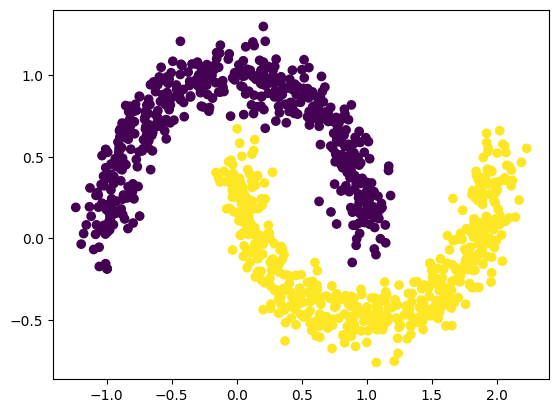

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input)
dataset['test_input'] = torch.from_numpy(test_input)
dataset['train_label'] = torch.from_numpy(train_label[:,None])
dataset['test_label'] = torch.from_numpy(test_label[:,None])

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0], X[:,1], c=y[:,0])

## Training with KAN

In [ ]:
from kan import KAN

model = KAN(width=[2,1], grid=3, k=3)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.58e-01 | test loss: 1.64e-01 | reg: 2.89e+00 : 100%|██| 20/20 [00:02<00:00,  7.02it/s]


(1.0, 0.9990000128746033)

In [ ]:
#test inference time
import time

avg_inf_time = 0

for index in range(100):
  s = time.time()
  model(dataset['test_input'][index:index+1,:])
  avg_inf_time += time.time()-s

print("AVG inference time: ",avg_inf_time/index)


AVG inference time:  0.0001743369632297092


In [ ]:
model.save_ckpt('ckpt1')

save this model to ./model_ckpt/ckpt1


## Training with Simple MLP Block

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

dataset['train_input'] = torch.from_numpy(train_input)
dataset['test_input'] = torch.from_numpy(test_input)
dataset['train_label'] = torch.from_numpy(train_label[:,None])
dataset['test_label'] = torch.from_numpy(test_label[:,None])

X_train = dataset['train_input'].double()
y_train = dataset['train_label'].double()
X_test = dataset['test_input'].double()
y_test = dataset['test_label'].double()

def train(model, criterion, optimizer, dataset, epochs=20):

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train(model, criterion, optimizer, dataset)

torch.save(model.state_dict(), 'model_weights.pth')

with torch.no_grad():
    predictions = model(X_test)
    predictions = (predictions > 0.5).float()
    accuracy = (predictions == y_test).sum() / y_test.shape[0]
    print(f'Test Accuracy: {accuracy.item():.4f}')


Epoch [1/20], Loss: 0.6977
Epoch [2/20], Loss: 0.4245
Epoch [3/20], Loss: 1.0103
Epoch [4/20], Loss: 0.3380
Epoch [5/20], Loss: 0.3742
Epoch [6/20], Loss: 0.3511
Epoch [7/20], Loss: 0.2547
Epoch [8/20], Loss: 0.1978
Epoch [9/20], Loss: 0.1914
Epoch [10/20], Loss: 0.1796
Epoch [11/20], Loss: 0.1434
Epoch [12/20], Loss: 0.1288
Epoch [13/20], Loss: 0.1175
Epoch [14/20], Loss: 0.0883
Epoch [15/20], Loss: 0.0775
Epoch [16/20], Loss: 0.0688
Epoch [17/20], Loss: 0.0477
Epoch [18/20], Loss: 0.0304
Epoch [19/20], Loss: 0.0241
Epoch [20/20], Loss: 0.0213
Test Accuracy: 0.9950


In [ ]:
#test inference time
import time

avg_inf_time = 0

for index in range(100):
  s = time.time()
  model(dataset['test_input'][index:index+1,:])
  avg_inf_time += time.time()-s

print("AVG inference time: ",avg_inf_time/index)

AVG inference time:  0.0003710371075254498


##  Conclusions


As expected, the KAN method achieves higher performance with a much narrower network compared to the MLP model.

Model sizes:

KAN: 18.79 K

MLP: 24.07 K

Inference time:

KAN: 0.00017 seconds

MLP: 0.00037 seconds